In [1]:
from pyspark import SparkContext
import datetime
import csv
import pandas            as pd
import numpy             as np
import matplotlib
import matplotlib.pyplot as plt
import sys #only needed to determine Python version number
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
sc = SparkContext()
filepath = r'./NYPD_Complaint_Data_Historic.csv'
# rdd = sc.textFile(filepath)
# header = rdd.first()
# rdd1 = rdd.filter(lambda row: row != header) \
#         .mapPartitions(lambda row: csv.reader(row)) \
#         .map(lambda row: (row[0], row[1], row[2], row[3], row[4], row[5], row[10], row[11])).cache()
rdd = sc.textFile(filepath).map(lambda l: csv.reader([l]).__next__())
header = rdd.first()
rdd = rdd.filter(lambda row: row != header).cache()

### Data Cleaning

In [16]:
def remove_null(row):
    for col in row:
        if col == '':
            return False

    return True

def transform(array):
    array[1] = datetime.datetime.strptime(array[1], '%m/%d/%Y')
    array[2] = datetime.datetime.strptime(array[2], '%H:%M:%S').time()
    return array

#replace year 1015
def replaceYear2015to2015(array):
    array[1] = array[1].replace('1015', '2015')
    return array

def replaceTime24to00(array):
    array[2] = array[2].replace('24:00:00', '00:00:00')
    return array

rdd1 = rdd.filter(lambda array: array[1] != '' and array[2] != '') \
    .map(replaceYear2015to2015) \
    .map(replaceTime24to00) \
    .map(transform) \
    .filter(lambda array: (array[1].year >= 2006 and array[1].year <= 2015)).cache()
# rdd2 = rdd1.filter(lambda row: remove_null(row)).cache()
    

In [17]:
## Some functions
def timeMap(x):
    if x[0].hour >= 0 and x[0].hour < 6:
        return ('Midnight',1)
    elif x[0].hour >= 6 and x[0].hour < 12:
        return ('Morning', 1)
    elif x[0].hour >= 12 and x[0].hour < 18:
        return ('Afternoon', 1)
    else:
        return ('Evening', 1)

In [65]:
## Plot functions
def plot_pie_chart(values_count, title):
    fig, ax = plt.subplots()
    ax.pie(np.array(values_count)[:, 1], labels = np.array(values_count)[:, 0], startangle=90, shadow=True, autopct='%1.0f%%')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.title.set_text(title)
    fig.set_size_inches(5, 5)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def plot_pie_charts(values_count1, title1, values_count2, title2):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    values1 = np.array(values_count1)[:, 1]
    values2 = np.array(values_count2)[:, 1]
    ax1.pie(values1, labels = np.array(values_count1)[:, 0], startangle=90, shadow=True, autopct='%1.0f%%')
    ax1.axis('equal')  
    ax1.title.set_text(title1)
    
    ax2.pie(values2, labels = np.array(values_count2)[:, 0], startangle=90, shadow=True, autopct='%1.0f%%')
    ax2.axis('equal')
    ax2.title.set_text(title2)
    
    fig.set_size_inches(15, 5)    

### Assumption 1  There is some relation between attempted crimes and time or level of offense.

In [18]:
# Filter out completed crimes at col 11
rdd2 = rdd1.filter(lambda row: row[10] == 'ATTEMPTED').cache()
# Level of offense in attempted crimes at col 12
attempted_lof = rdd2.map(lambda row: (row[11], 1)) \
    .reduceByKey(lambda x,y: x + y)

In [6]:
atmpt_lof_data = attempted_lof.collect()

In [7]:
atmpt_lof_data

[('FELONY', 62409), ('VIOLATION', 1748), ('MISDEMEANOR', 23542)]

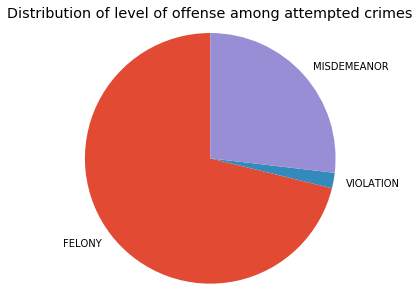

In [41]:
plot_pie_chart(atmpt_lof_data, "Distribution of level of offense among attempted crimes")

In [9]:
# Let's see completed crimes:
rdd3 = rdd1.filter(lambda row: row[10] == 'COMPLETED').cache()
# Level of offense in completed crimes
completed_lof = rdd3.map(lambda row: (row[11], 1)) \
    .reduceByKey(lambda x,y: x + y)
cmplt_lof_data = completed_lof.collect()

In [10]:
cmplt_lof_data

[('FELONY', 1494129), ('VIOLATION', 612165), ('MISDEMEANOR', 2887755)]

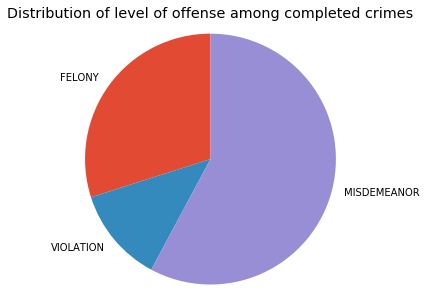

In [42]:
plot_pie_chart(cmplt_lof_data, "Distribution of level of offense among completed crimes")

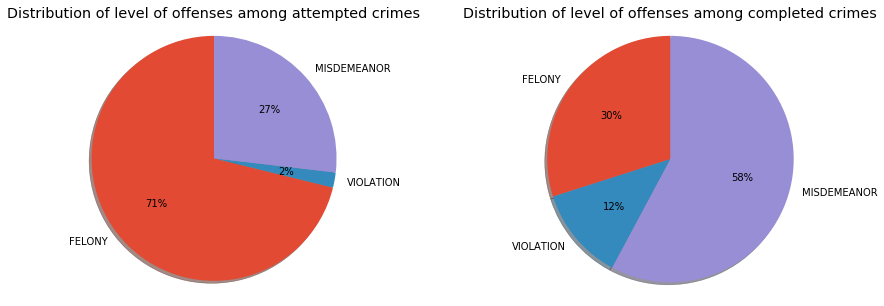

In [62]:
plot_pie_charts(atmpt_lof_data, "Distribution of level of offenses among attempted crimes", cmplt_lof_data, "Distribution of level of offenses among completed crimes")

In [12]:
## See when the attempted crimes happen
atmpt_time_count = rdd2.map(lambda row: (row[2], row[11])) \
                       .map(timeMap) \
                       .reduceByKey(lambda x, y: x + y) \
                       .collect()

In [73]:
atmpt_time_count

[('Afternoon', 29284),
 ('Morning', 15734),
 ('Midnight', 16901),
 ('Evening', 25780)]

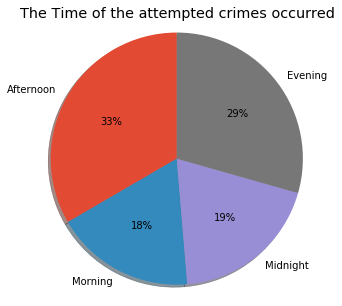

In [67]:
plot_pie_chart(atmpt_time_count, "The Time of the attempted crimes occurred")

In [74]:
## See when the completed crimes happen
cmplt_time_count = rdd3.map(lambda row: (row[2], row[11])) \
                       .map(timeMap) \
                       .reduceByKey(lambda x, y: x + y) \
                       .collect()

In [75]:
cmplt_time_count

[('Afternoon', 1647515),
 ('Morning', 909218),
 ('Midnight', 833588),
 ('Evening', 1603728)]

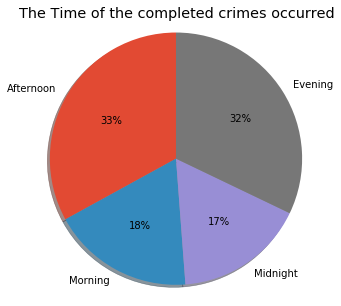

In [76]:
plot_pie_chart(cmplt_time_count, "The Time of the completed crimes occurred")

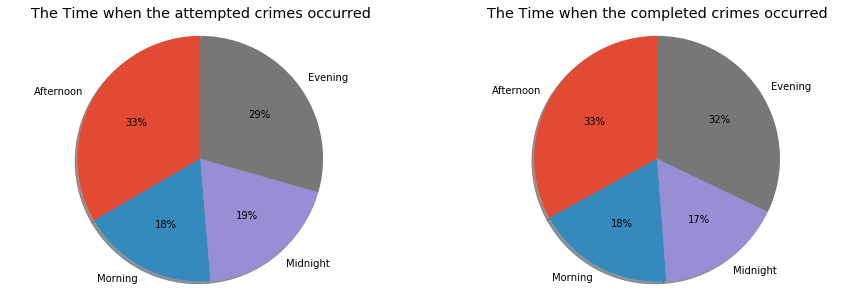

In [ ]:
plot_pie_charts(atmpt_time_count, "The Time when the attempted crimes occurred", cmplt_time_count, "The Time when the completed crimes occurred")

In [ ]:
## Time distribution for felony in attempted crime
time_attempted_felony = rdd2.map(lambda row: (row[2], row[11])) \
                         .filter(lambda row: row[1] == "FELONY") \
                         .map(timeMap) \
                         .reduceByKey(lambda x, y: x + y) \
                         .collect()                         

In [ ]:
time_attempted_felony

In [ ]:
plot_pie_chart(time_attempted_felony, "The Time when the attempted felony occurred")

In [ ]:
## Time distribution for felony in completed crime
time_completed_felony = rdd3.map(lambda row: (row[2], row[11])) \
                         .filter(lambda row: row[1] == "FELONY") \
                         .map(timeMap) \
                         .reduceByKey(lambda x, y: x + y) \
                         .collect()

In [ ]:
time_completed_felony

In [ ]:
plot_pie_chart(time_completed_felony, "The Time when the completed felony occurred")

In [ ]:
plot_pie_charts(time_attempted_felony, "The Time when the attempted felony occurred", time_completed_felony, "The Time when the completed felony occurred")

In [ ]:
## Time distribution for misdemeanor in completed crime
time_completed_misdemeanor = rdd3.map(lambda row: (row[2], row[11])) \
                         .filter(lambda row: row[1] == "MISDEMEANOR") \
                         .map(timeMap) \
                         .reduceByKey(lambda x, y: x + y) \
                         .collect()

In [ ]:
time_completed_misdemeanor

In [ ]:
plot_pie_chart(time_completed_misdemeanor)